# Comparison of PyBaMM and COMSOL Discharge Curves

In this notebook we compare the discharge curves obatined by solving the DFN model both in PyBaMM and COMSOL. Results are presented for a range of C-rates, and we see an excellent agreement between the two implementations. If you would like to compare internal varibles please see the script [compare_comsol_DFN](https://github.com/pybamm-team/PyBaMM/blob/comsol-voltage-compare/examples/scripts/compare_comsol/compare_comsol_DFN.py) which creates a slider plot comparing potentials and concentrations as functions of time and space for a given C-rate. For more information on the DFN model, see the [DFN notebook](https://github.com/pybamm-team/PyBaMM/blob/master/examples/notebooks/models/DFN.ipynb).

First we need to import pybamm, and then change our working directory to the root of the pybamm folder.

In [1]:
import pybamm
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0] + "/..")

We then create a dictionary of the C-rates we would like to solve for and compare. Note that the repository currently only contains COMSOL results for the C-rates listed below. 

In [2]:
C_rates = {"01": 0.1, "05": 0.5, "1": 1, "2": 2, "3": 3}

We get the DFN model equations, geometry, and default parameters. Before processign the model, we adjust the electrode height and depth to be 1 m, to match the one-dimensional model we solved in COMSOL. The model is then processed using the default geometry and updated paramters. Finally, we create a mesh and discretise the model. 

In [3]:
# load model and geometry
model = pybamm.lithium_ion.DFN()
geometry = model.default_geometry

# load parameters and process model and geometry
param = model.default_parameter_values
param["Electrode width [m]"] = 1
param["Electrode height [m]"] = 1
param.process_model(model)
param.process_geometry(geometry)

# create mesh
var = pybamm.standard_spatial_vars
var_pts = {var.x_n: 31, var.x_s: 11, var.x_p: 31, var.r_n: 11, var.r_p: 11}
mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model);

We create the figure by looping over the dictionary of C-rates. In each step of the loop we load the COMSOL results from a .csv file and solve the DFN model in pybamm. The output variables are then processed, allowing us to plot the discharges curve computed using pybamm and COMSOL, and their absolute difference.  

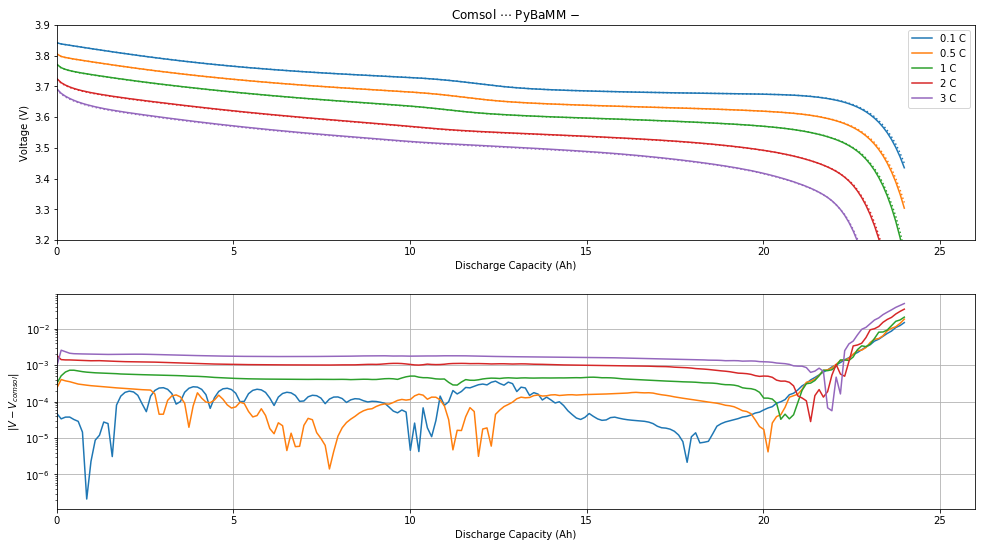

In [4]:
# create figure
fig, ax = plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplots_adjust(left=-0.1)
discharge_curve = plt.subplot(211)
plt.xlim([0, 26])
plt.ylim([3.2, 3.9])
plt.xlabel(r"Discharge Capacity (Ah)")
plt.ylabel("Voltage (V)")
plt.title(r"Comsol $\cdots$ PyBaMM $-$")
voltage_difference_plot = plt.subplot(212)
plt.xlim([0, 26])
plt.yscale("log")
plt.grid(True)
plt.xlabel(r"Discharge Capacity (Ah)")
plt.ylabel(r"$\vert V - V_{comsol} \vert$")

# loop over C_rates dict to create plot
for key, C_rate in C_rates.items():

    # load the comsol results
    comsol_variables = pickle.load(open("input/comsol_results/comsol_{}C.pickle".format(key), 'rb'))
    comsol_time = comsol_variables["time"]
    comsol_voltage = comsol_variables["voltage"]

    # update current density
    param["Current function [A]"] = 24 * C_rate
    param.update_model(model, disc)

    # discharge timescale
    tau = param.process_symbol(
        pybamm.standard_parameters_lithium_ion.tau_discharge
    ).evaluate(0, 0)

    # solve model at comsol times
    solver = pybamm.CasadiSolver(mode="fast")
    t = comsol_time / tau
    solution = solver.solve(model, t)

    # discharge capacity
    discharge_capacity = pybamm.ProcessedVariable(
        model.variables["Discharge capacity [A.h]"], solution.t, solution.y, mesh=mesh
    )
    discharge_capacity_sol = discharge_capacity(solution.t)
    comsol_discharge_capacity = comsol_time * param["Current function [A]"] / 3600

    # extract the voltage
    voltage = pybamm.ProcessedVariable(
        model.variables["Terminal voltage [V]"], solution.t, solution.y, mesh=mesh
    )
    voltage_sol = voltage(solution.t)

    # calculate the difference between the two solution methods
    end_index = min(len(solution.t), len(comsol_time))
    voltage_difference = np.abs(voltage_sol[0:end_index] - comsol_voltage[0:end_index])

    # plot discharge curves and absolute voltage_difference
    color = next(ax._get_lines.prop_cycler)["color"]
    discharge_curve.plot(
        comsol_discharge_capacity, comsol_voltage, color=color, linestyle=":"
    )
    discharge_curve.plot(
        discharge_capacity_sol,
        voltage_sol,
        color=color,
        linestyle="-",
        label="{} C".format(C_rate),
    )
    voltage_difference_plot.plot(
        discharge_capacity_sol[0:end_index], voltage_difference, color=color
    )

discharge_curve.legend(loc="best")
plt.subplots_adjust(
    top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35
)
plt.show()